In [5]:
%load_ext autoreload
%autoreload 2

import abtem
import ase
import numpy as np
from abtem.noise import poisson_noise
import py4DSTEM
import matplotlib.pyplot as plt
import cmasher as cmr
from scipy.ndimage import rotate
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
outer_cnt = ase.build.nanotube(12, 8, length=1)
inner_cnt = ase.build.nanotube(6, 4, length=1)
double_walled_cnt = outer_cnt + inner_cnt
double_walled_cnt.center(vacuum=10, axis=(0,1))

# double_walled_cnt.rotate('x', 'z', rotate_cell=True)
# manual rotation
positions = double_walled_cnt.positions
positions_new = positions.copy()
positions_new[:,0] = positions[:,2]
positions_new[:,2] = positions[:,0]

double_walled_cnt = ase.Atoms(
    double_walled_cnt.symbols,
    positions = positions_new,
    cell=np.array([
        double_walled_cnt.cell[2,2],
        double_walled_cnt.cell[1,1],
        double_walled_cnt.cell[0,0]
    ])
)

double_walled_cnt.positions[:,0] += 20
double_walled_cnt.positions[:,1] += 20
double_walled_cnt.cell[0][0] += 40
double_walled_cnt.cell[1][1] += 40

<Axes: xlabel='x [Å]', ylabel='y [Å]'>

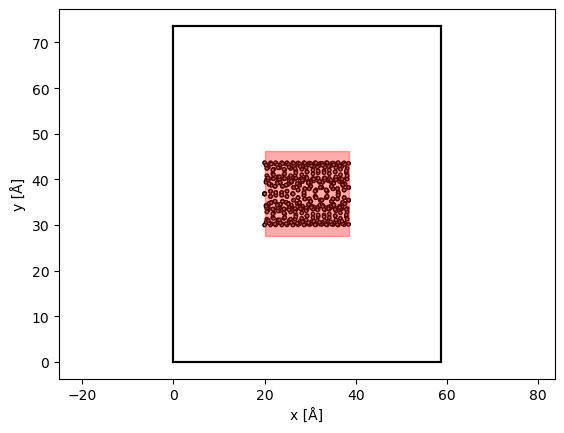

In [25]:
abtem.show_atoms(
    double_walled_cnt,
    scans=grid_scan
)

In [9]:
frozen_phonons = abtem.temperature.FrozenPhonons(double_walled_cnt, 12, 0.075)

potential = abtem.Potential(
    double_walled_cnt,
    sampling=0.08,
    device="gpu",
    projection="infinite",
    parametrization="kirkland",
)

probe = abtem.Probe(semiangle_cutoff=25, energy=80e3, defocus=200,device="gpu")
probe.match_grid(potential)

# resample = 2*probe.rectangle_cutoff_scattering_angles[1]/96
# pixelated_detector = abtem.PixelatedDetector(resample=(resample,resample))
pixelated_detector = abtem.PixelatedDetector(resample = "uniform", max_angle = 30)

grid_scan = abtem.GridScan(
    (20, potential.extent[1]/2-potential.extent[0]/2 + 20 ), (potential.extent[0]-20,potential.extent[1]/2+potential.extent[0]/2-20),
    gpts=((36+1),(36+1)),
    endpoint=True
)

# grid_scan = abtem.GridScan(
#     (20, potential.extent[1]/2-potential.extent[0]/2 + 20 ), (potential.extent[0]-20,potential.extent[1]/2+potential.extent[0]/2-20),
#     gpts=((36 + 1),(24)),
#     endpoint=True
# )
measurement = probe.scan(grid_scan, pixelated_detector, potential)


Potential:   0%|          | 0/68 [00:00<?, ?it/s]

Scan:   0%|          | 0/1369 [00:00<?, ?it/s]

In [4]:
measurement = abtem.Measurement.read('parallax_lowres.h5')

In [10]:
measurement.calibrations[-1].sampling

0.7129578047101401

In [33]:
# measurement.write('parallax_lowres.h5')

In [31]:
poisson_noise(measurement, 1e5).array.max()

`product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.


23.0

In [29]:
measurement.array.max()

0.00032505248

In [11]:
measurement_noise = poisson_noise(measurement, 1e5)

`product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.


In [12]:
dc = py4DSTEM.DataCube(data = measurement_noise.array)
dc.calibration.set_R_pixel_size(measurement_noise.calibrations[0].sampling)
dc.calibration.set_R_pixel_units('A')
dc.calibration.set_Q_pixel_size(measurement_noise.calibrations[-1].sampling)
dc.calibration.set_Q_pixel_units('mrad')

In [13]:
bin_factor = 4
dc_binned = dc.copy()
dc_binned.bin_Q(bin_factor)

DataCube( A 4-dimensional array of shape (37, 37, 21, 21) called 'datacube',
          with dimensions:

              Rx = [0.0,0.515803041652313,1.031606083304626,...] A
              Ry = [0.0,0.515803041652313,1.031606083304626,...] A
              Qx = [0.0,2.8518312188405606,5.703662437681121,...] mrad
              Qy = [0.0,2.8518312188405606,5.703662437681121,...] mrad
)

In [14]:
for a0 in range(dc.Rshape[0]):
    for a1 in range(dc.Rshape[1]):
        dc.data[a0,a1] = rotate(dc.data[a0,a1], angle = -17, reshape = False)
        dc_binned.data[a0,a1] = rotate(dc_binned.data[a0,a1], angle = -17, reshape = False)

Best fit rotation forced to 17 degrees.
Transpose of intensities forced to False.


DPC( A Node called 'dpc_reconstruction', containing the following top-level objects in its tree:

)

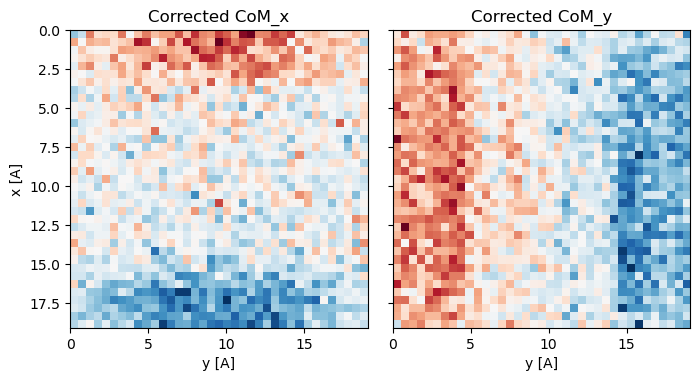

In [15]:
DPC = py4DSTEM.process.phase.DPC(
    dc, 
    energy = 80e3, 
    # dp_mask = dp_mask
)

DPC.preprocess(
    fit_function="constant",
    force_com_rotation=17,
    force_com_transpose=False
)


Reconstructing phase:   0%| | 0/64 [00:00<?, ? iter/s
Reconstructing phase: 100%|█| 64/64 [00:00<00:00, 589


DPC( A Node called 'dpc_reconstruction', containing the following top-level objects in its tree:

)

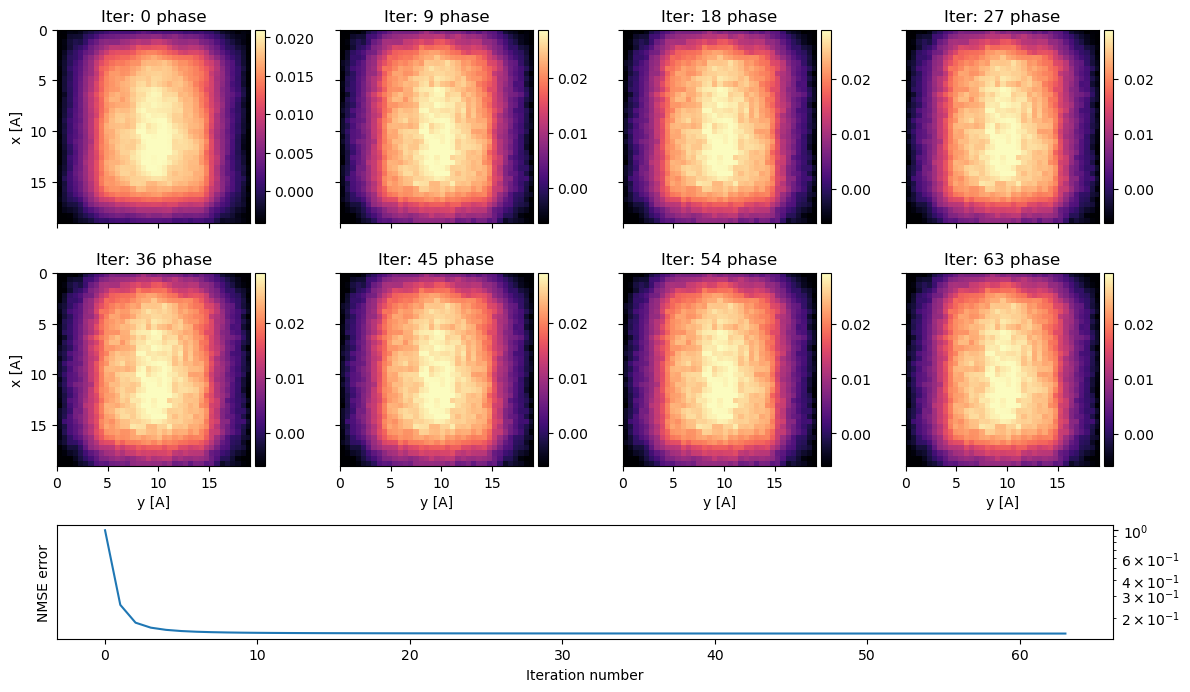

In [16]:
DPC.reconstruct(
    store_iterations = True, 
    # gaussian_filter_sigma=0.5, 
    q_lowpass=1.5,
    reset = True, 
    # q_highpass = 0.4
).visualize(plot_convergence = True, iterations_grid = "auto")

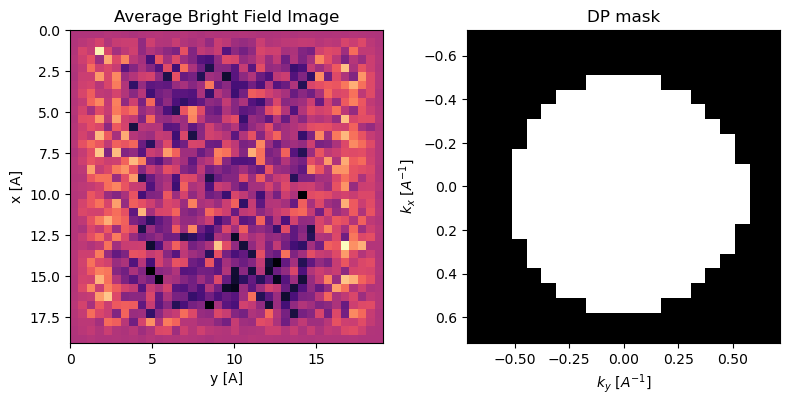

In [17]:
parallax_high_bin = py4DSTEM.process.phase.Parallax(
    datacube = dc_binned, 
    energy = 80e3, 
    verbose= True,
).preprocess(
    normalize_images = True,
    edge_blend = 4,
    threshold_intensity = 0.75,
    # rotation_guess=17,
    # defocus_guess=250
)

Alignment at bin 8: 100%|█| 6/6 [00:00<00:00, 589.79 
Alignment at bin 4: 100%|█| 16/16 [00:00<00:00, 931.1
Alignment at bin 4: 100%|█| 16/16 [00:00<00:00, 1028.
Alignment at bin 4: 100%|█| 16/16 [00:00<00:00, 1335.
Alignment at bin 4: 100%|█| 16/16 [00:00<00:00, 1065.
Alignment at bin 4: 100%|█| 16/16 [00:00<00:00, 1062.
Alignment at bin 4: 100%|█| 16/16 [00:00<00:00, 1059.
Alignment at bin 4: 100%|█| 16/16 [00:00<00:00, 1056.
Alignment at bin 4: 100%|█| 16/16 [00:00<00:00, 1064.


Rotation of Q w.r.t. R = 17.073 deg
Astigmatism (A1x,A1y)  = (4,0) Ang
Aberration C1          =  -165 Ang
Defocus dF             = 165 Ang
Transpose              = False


Parallax( A Node called 'parallax_reconstruction', containing the following top-level objects in its tree:

)

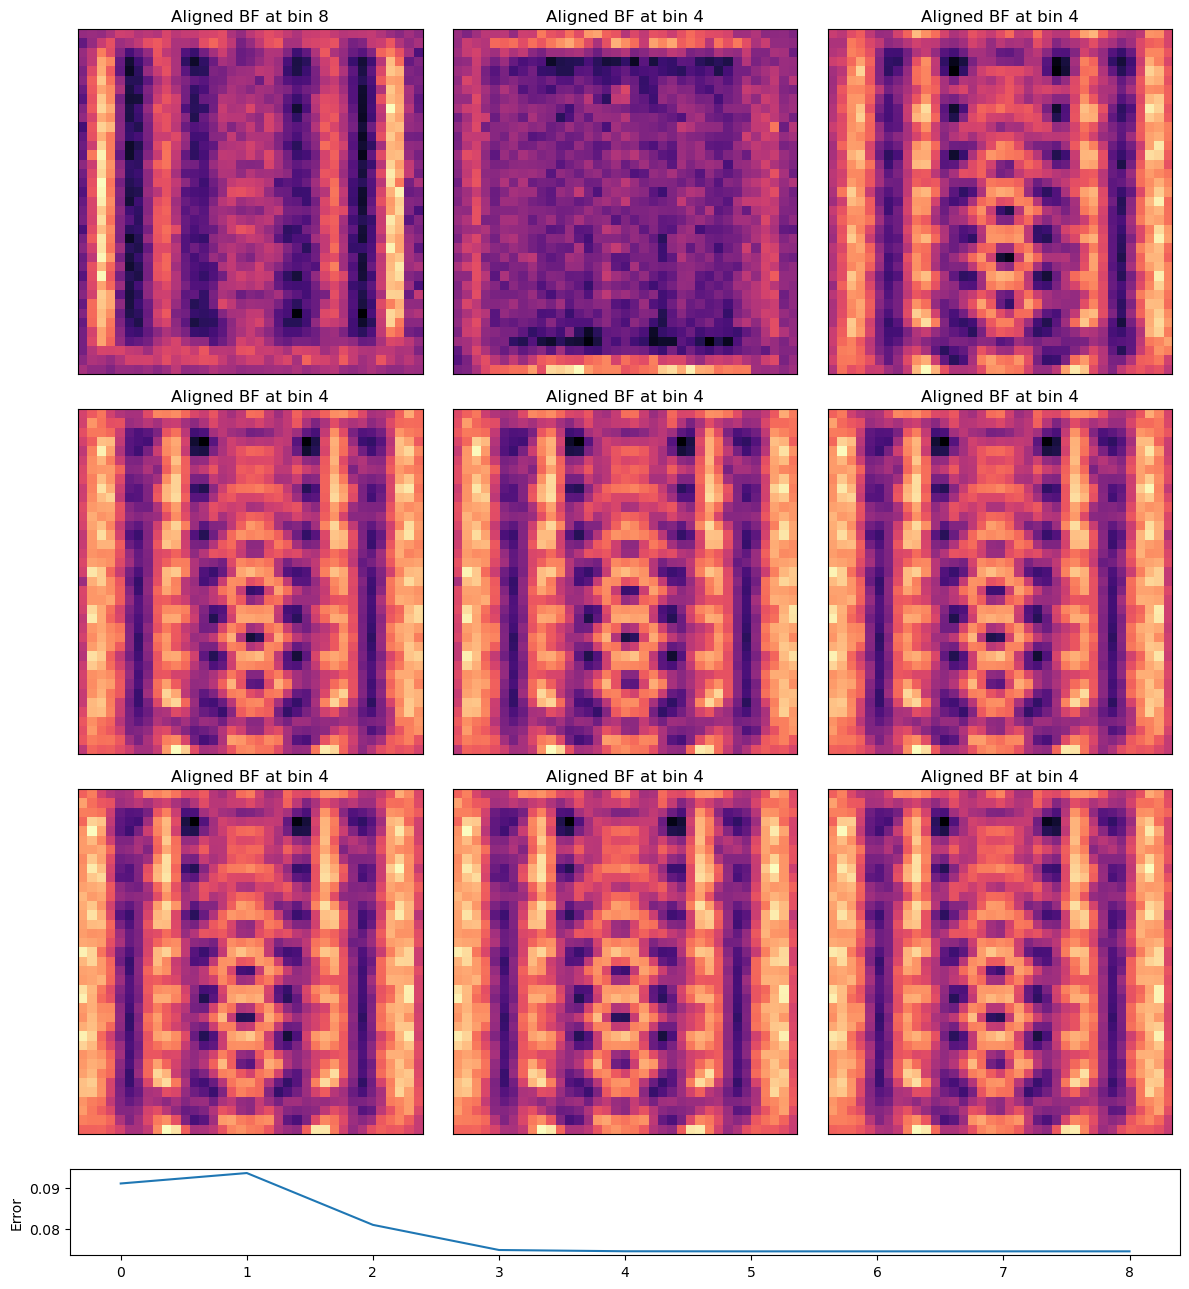

In [18]:
parallax_high_bin.reconstruct(
    # max_alignment_bin = 8,
    min_alignment_bin = 4,
    num_iter_at_min_bin =  8,
    reset = True,
    # regularizer_matrix_size = (2,2)
)

parallax_high_bin.aberration_fit()

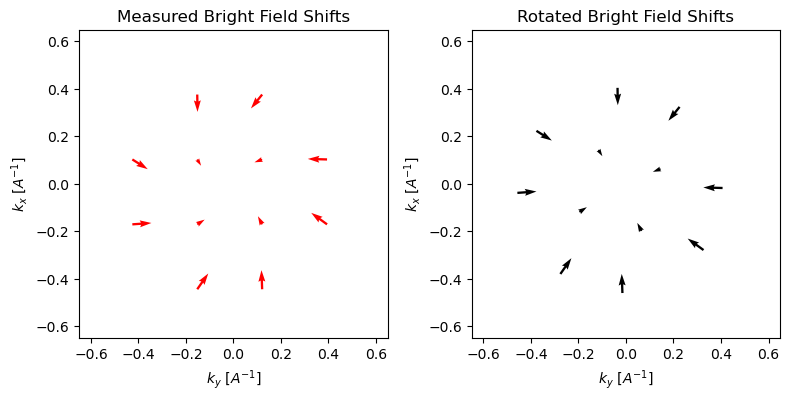

In [19]:
parallax_high_bin.show_shifts(
    scale_arrows=0.2, plot_arrow_freq= 4
)

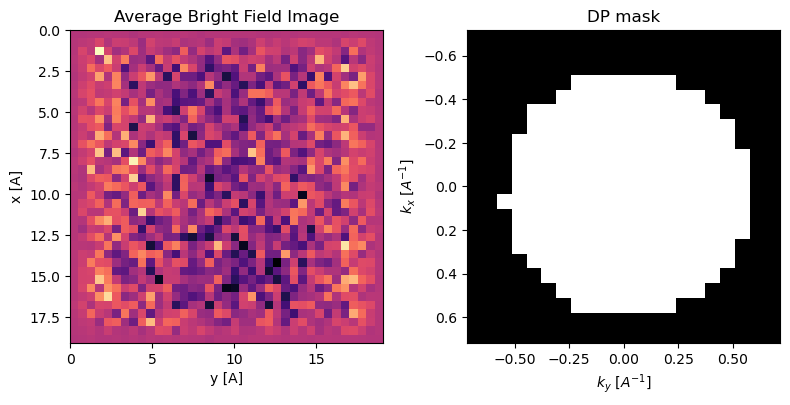

In [20]:
parallax_low_bin = py4DSTEM.process.phase.Parallax(
    datacube = dc_binned, 
    energy = 80e3, 
    verbose= True,
).preprocess(
    normalize_images = True,
    edge_blend = 4,
    threshold_intensity = 0.5,
    # rotation_guess=17,
    # defocus_guess=250
)

Alignment at bin 16: 100%|█| 4/4 [00:00<00:00, 631.72
Alignment at bin 8: 100%|█| 6/6 [00:00<00:00, 852.10 
Alignment at bin 4: 100%|█| 17/17 [00:00<00:00, 942.6
Alignment at bin 2: 100%|█| 59/59 [00:00<00:00, 1111.
Alignment at bin 1: 100%|█| 114/114 [00:00<00:00, 114
Alignment at bin 1: 100%|█| 114/114 [00:00<00:00, 115
Alignment at bin 1: 100%|█| 114/114 [00:00<00:00, 114
Alignment at bin 1: 100%|█| 114/114 [00:00<00:00, 115
Alignment at bin 1: 100%|█| 114/114 [00:00<00:00, 115
Alignment at bin 1: 100%|█| 114/114 [00:00<00:00, 111
Alignment at bin 1: 100%|█| 114/114 [00:00<00:00, 114
Alignment at bin 1: 100%|█| 114/114 [00:00<00:00, 114


Rotation of Q w.r.t. R = 17.073 deg
Astigmatism (A1x,A1y)  = (4,0) Ang
Aberration C1          =  -165 Ang
Defocus dF             = 165 Ang
Transpose              = False


Parallax( A Node called 'parallax_reconstruction', containing the following top-level objects in its tree:

)

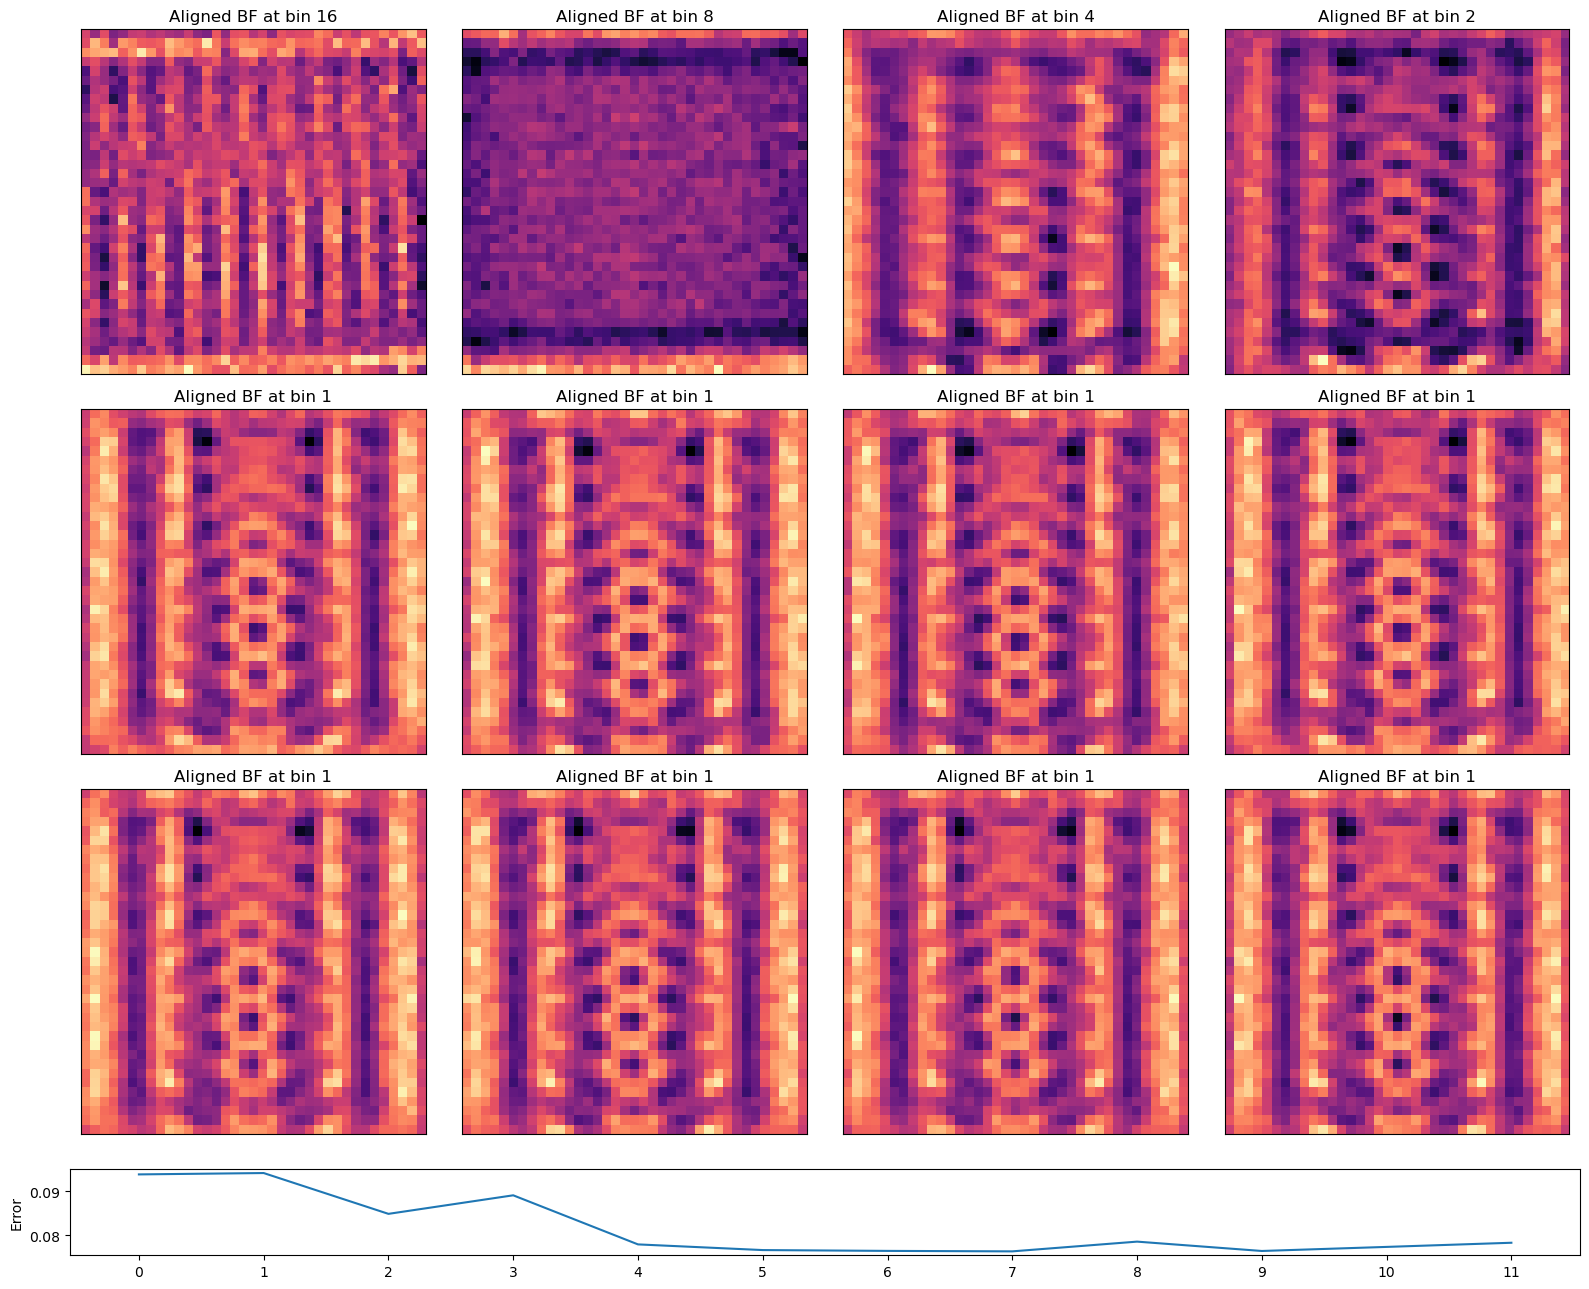

In [21]:
parallax_low_bin.reconstruct(
    # max_alignment_bin = 8,
    min_alignment_bin = 1,
    num_iter_at_min_bin =  8,
    reset=True,
    # regularizer_matrix_size = (2,2)
)

parallax_high_bin.aberration_fit()

Rotation of Q w.r.t. R = 18.153 deg
Astigmatism (A1x,A1y)  = (-2,-0) Ang
Aberration C1          =  -153 Ang
Defocus dF             = 153 Ang
Transpose              = False


Parallax( A Node called 'parallax_reconstruction', containing the following top-level objects in its tree:

)

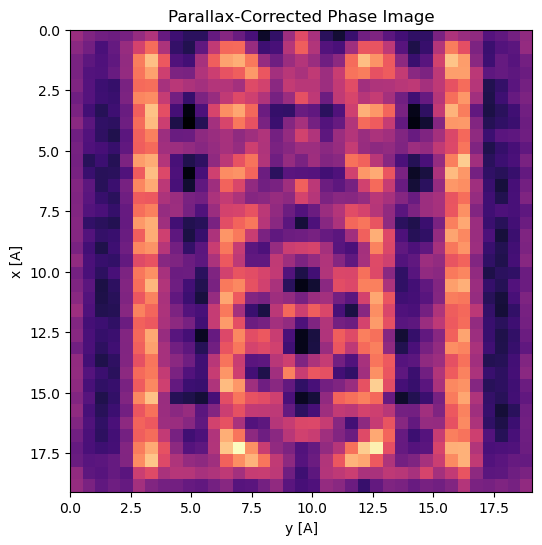

In [22]:
parallax_low_bin.aberration_fit(
    plot_CTF_compare=True,
    plot_dk = 0.01
)
# parallax_low_bin.aberration_C1 = -200
parallax_low_bin.aberration_correct()

In [47]:
parallax_unbinned_phase_image = parallax_low_bin.object_cropped.copy()

Dark-field upsampling limit of 0.74 is less than 1, implying a scan step-size smaller than Nyquist. setting to 1.
Requested upsampling factor exceeds dark-field upsampling limit of 1.00.


Parallax( A Node called 'parallax_reconstruction', containing the following top-level objects in its tree:

)

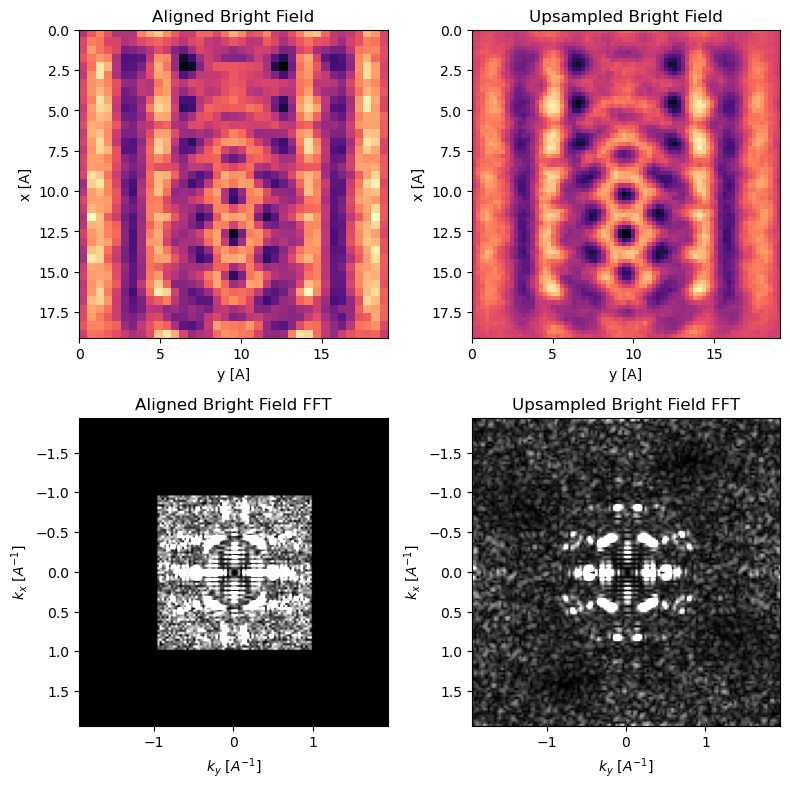

In [23]:
parallax_low_bin.subpixel_alignment(
    plot_upsampled_FFT_comparison=True,
    kde_upsample_factor=2,
)

Parallax( A Node called 'parallax_reconstruction', containing the following top-level objects in its tree:

)

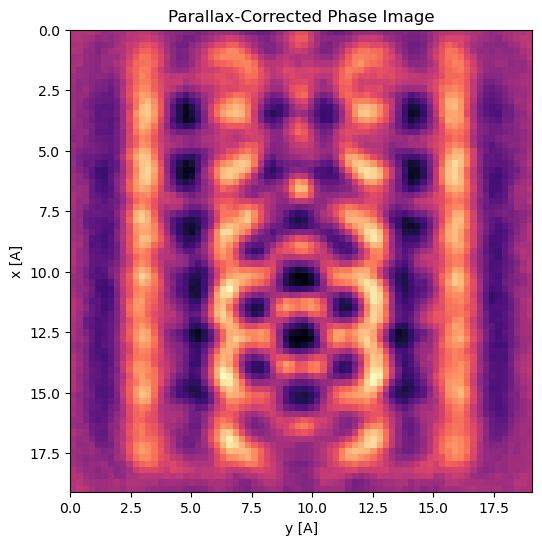

In [24]:
parallax_low_bin.aberration_correct()

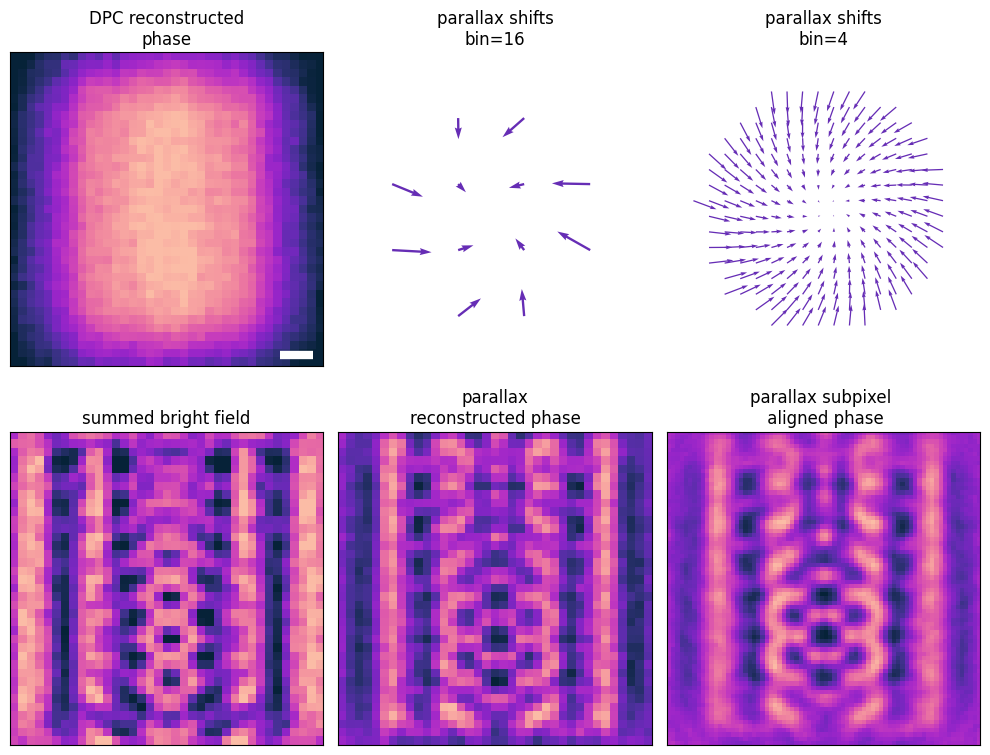

In [50]:
fig, ax = plt.subplots(2,3,figsize = (10,8))

cmap = cmr.bubblegum

py4DSTEM.show(
    DPC.object_phase, 
    figax = (fig, ax[0,0]), 
    ticks = False, 
    title = "DPC reconstructed\nphase", 
    cmap = cmap,
    scalebar ={
        'label' : False,
    }, #2A
    pixelsize= dc.calibration.get_R_pixel_size(),
    pixelunits = "A",
)

scale_arrows=0.4
plot_arrow_freq= 4

dp_mask_ind = np.nonzero(parallax_high_bin._dp_mask)
yy, xx = np.meshgrid(
    np.arange(parallax_high_bin._dp_mask.shape[1]), np.arange(parallax_high_bin._dp_mask.shape[0])
)
freq_mask = np.logical_and(xx % plot_arrow_freq == 0, yy % plot_arrow_freq == 0)
masked_ind = np.logical_and(freq_mask, parallax_high_bin._dp_mask)
plot_ind = masked_ind[dp_mask_ind]

ax[0,1].quiver(
    parallax_high_bin._kxy[plot_ind, 1],
    parallax_high_bin._kxy[plot_ind, 0],
    parallax_high_bin._xy_shifts[plot_ind, 1]
    * scale_arrows
    * parallax_high_bin._reciprocal_sampling[0]
    ,
    parallax_high_bin._xy_shifts[plot_ind, 0]
    * scale_arrows
    * parallax_high_bin._reciprocal_sampling[1]
    ,
    color='#662DB5',
    angles="xy",
    scale_units="xy",
    scale=1,
)

kr_max = np.max(parallax_high_bin._kr)
ax[0,1].set_xlim([-1.2 * kr_max, 1.2 * kr_max])
ax[0,1].set_ylim([-1.2 * kr_max, 1.2 * kr_max])
ax[0,1].set_aspect('equal')
ax[0,1].axis('off')
ax[0,1].set_title('parallax shifts\nbin=16')


scale_arrows=0.2
plot_arrow_freq= 1

dp_mask_ind = np.nonzero(parallax_low_bin._dp_mask)
yy, xx = np.meshgrid(
    np.arange(parallax_low_bin._dp_mask.shape[1]), np.arange(parallax_low_bin._dp_mask.shape[0])
)
freq_mask = np.logical_and(xx % plot_arrow_freq == 0, yy % plot_arrow_freq == 0)
masked_ind = np.logical_and(freq_mask, parallax_low_bin._dp_mask)
plot_ind = masked_ind[dp_mask_ind]

ax[0,2].quiver(
    parallax_low_bin._kxy[plot_ind, 1],
    parallax_low_bin._kxy[plot_ind, 0],
    parallax_low_bin._xy_shifts[plot_ind, 1]
    * scale_arrows
    * parallax_low_bin._reciprocal_sampling[0]
    ,
    parallax_low_bin._xy_shifts[plot_ind, 0]
    * scale_arrows
    * parallax_low_bin._reciprocal_sampling[1]
    ,
    color='#662DB5',
    angles="xy",
    scale_units="xy",
    scale=1,
)

kr_max = np.max(parallax_low_bin._kr)
ax[0,2].set_xlim([-1.2 * kr_max, 1.2 * kr_max])
ax[0,2].set_ylim([-1.2 * kr_max, 1.2 * kr_max])
ax[0,2].set_aspect('equal')
ax[0,2].axis('off')
ax[0,2].set_title('parallax shifts\nbin=4')


p = parallax_low_bin._object_padding_px[0]//2
py4DSTEM.show(
    parallax_low_bin.recon_BF[p:-p,p:-p], 
    figax = (fig, ax[1,0]), 
    ticks = False, 
    title = "summed bright field", 
    cmap = cmap
)


py4DSTEM.show(
    parallax_unbinned_phase_image, 
    figax = (fig, ax[1,1]), 
    ticks = False, 
    title = "parallax\nreconstructed phase", 
    cmap = cmap,
    vmax = 1,
    vmin = 0
)


py4DSTEM.show(
    parallax_low_bin.object_cropped, 
    figax = (fig, ax[1,2]), 
    ticks = False, 
    title = "parallax subpixel \n aligned phase", 
    cmap = cmap,
    vmax = 1,
    vmin = 0
)

plt.tight_layout()
# plt.savefig('parallax.svg', dpi = 350, bbox_inches = "tight", pad_inches = 0.1)

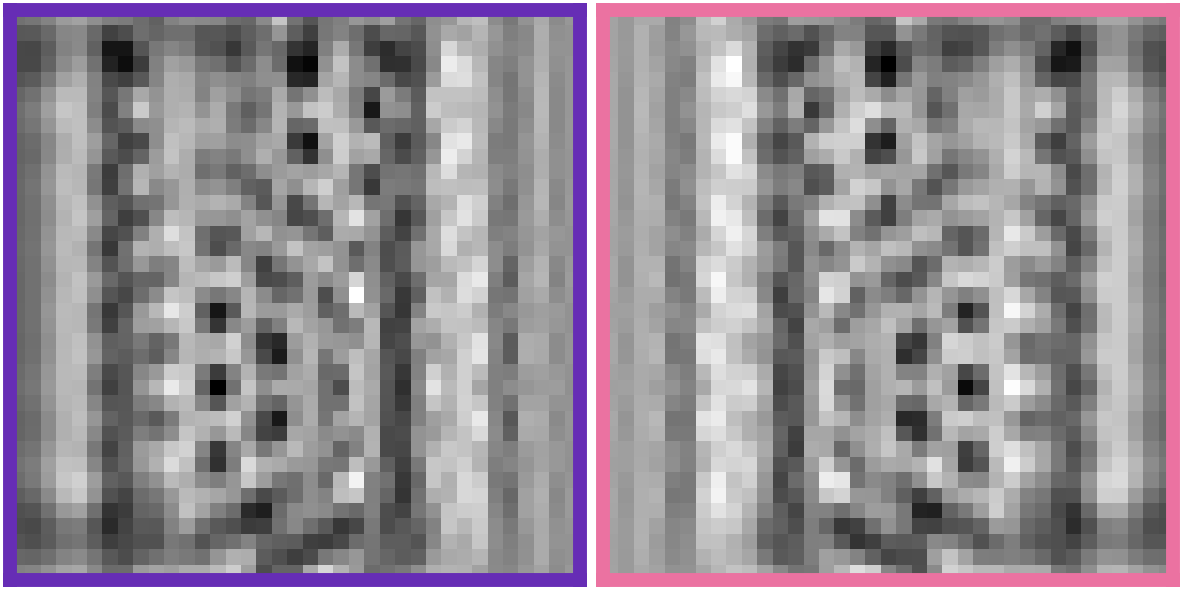

In [51]:
pixel_size = 3
dc_no_noise = py4DSTEM.DataCube(data = measurement.array)
left_no_noise = np.mean(dc_no_noise[:,:,43-pixel_size:43+pixel_size,17:22], axis = (2,3))

right_no_noise = np.mean(dc_no_noise[:,:,43-pixel_size:43+pixel_size,65:72], axis = (2,3))

# fig, ax = plt.subplots(1,2, figsize = (4,12))
fig, ax = py4DSTEM.visualize.show_image_grid(
    get_ar = lambda i :[
        left_no_noise,
        right_no_noise
    ][i], 
    H = 1,
    W = 2,
    cmap = "gray", 
    ticks= False,
    get_bordercolor= lambda i:['#662DB5','#EB72A1'][i],
    borderwidth=10,
    returnfig = True,
    vmax = 1,
    vmin = 0,
    # figax = (fig, ax)
)

plt.savefig('left_right.svg', dpi = 350)
